In [3]:
%load_ext autoreload
%autoreload 2

from lablr import *
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


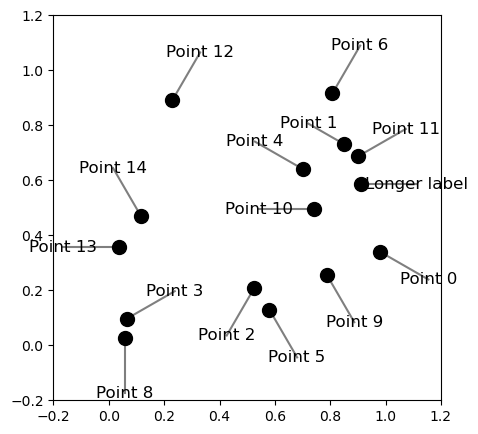

In [9]:
points = np.random.uniform(0, 1, (15, 2))
labels = [f"Point {i}" for i in range(len(points))]
labels[7] = "Longer label"

allowed_radii = [0.05, 0.1, 0.15, 0.2]
allowed_angles = np.linspace(0, 360, 12, endpoint=False)

fig, ax = plt.subplots(figsize=(5, 5))

best_label_pos, best_label_energies, lowest_energy = optimize_label_positions(
    ax,
    points,
    labels,
    allowed_radii=allowed_radii,
    allowed_angles=allowed_angles,
    n_random_iterations=100,
    n_local_iterations=1
)

plt.scatter(points[:, 0], points[:, 1], s=100, c="black", zorder=2)

for i, label in enumerate(labels):
    label_pos = best_label_pos[i]
    ax.text(
        label_pos[0],
        label_pos[1],
        label,
        fontsize=12,
        ha="center",
        va="center",
        zorder=3,
    )

for i, point in enumerate(points):
    plt.plot([point[0], best_label_pos[i, 0]], [point[1], best_label_pos[i, 1]], c='k', alpha=0.5)

plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.show()